1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [209]:
import pandas as pd
import pickle
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

Solution at (x,y) = 1,1:  [-0.08984202  0.7126564 ] 



NameError: name 'solutions' is not defined

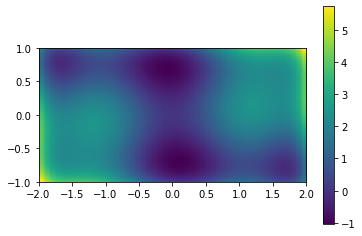

In [210]:
def f(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]
            + (-4 + 4*x[1]**2) * x[1] **2)

x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)
plt.figure()
plt.imshow(f([xg, yg]), extent=[-2, 2, -1, 1], origin="lower")
plt.colorbar()


#finding the global minima
solution = optimize.minimize(f, x0 = [0.5, 0.5])
print('Solution at (x,y) = 1,1: ', solution['x'], '\n')
plt.scatter(solutions.x[0], solutions.x[1], color='white')

#What happens for an initial guess of (x,y)=(0,0)?
solution1 = optimize.minimize(f, x0=[0, 0])
print('At initial guess (x, y) = 0, the solution1 is:', solution1['x'])
plt.scatter(solution1.x[0], solution1.x[1], color='black')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

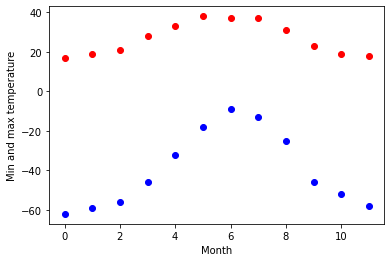

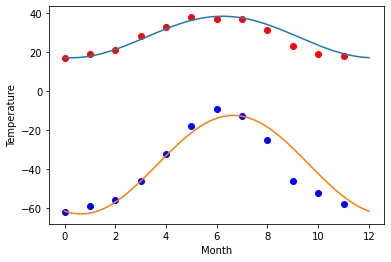

The fit is reasonable


In [211]:
#plotting temperatures
max_temp = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.arange(12)
plt.plot(months, max_temp, 'ro' )
plt.plot(months, min_temp, 'bo')
plt.xlabel('Month')
plt.ylabel('Min and max temperature')

#describing a function to fit the temperatures
def annual_temps(time, average, amplitude, time_offset):
    return (average + amplitude * np.cos((time + time_offset) * 2 * np.pi / time.max()))

res_max, cov_max = optimize.curve_fit(annual_temps, months, max_temp, [20, 10, 0])
res_min, cov_min = optimize.curve_fit(annual_temps, months, min_temp, [-40, 20, 0])

#Plot the result. 
days = np.linspace(0, 12, num=365)
plt.figure()
plt.plot(months, max_temp, 'ro')
plt.plot(days, annual_temps(days, *res_max))
plt.plot(months, min_temp, 'bo')
plt.plot(days, annual_temps(days, *res_min))
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.show()

print('The fit is reasonable')

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

Text(0, 0.5, 'samples')

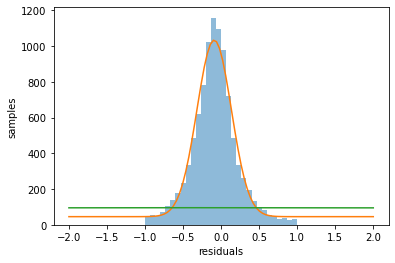

In [212]:
content = pd.read_pickle('data/residuals_261.pkl')
data = np.array(content, ndmin=1)[0]
df = pd.DataFrame(data)
df = df[df['residuals'].abs() < 1.]


def gaussian(x, a, b, x0, sigma): return a*np.exp( -(x - x0)**2 / (2*sigma**2) ) + b

def laplace(x, a, b, c, x0): return a*np.exp( - np.abs(x-x0) / b) + c


residuals = df['residuals'].to_numpy()

plt.figure()

# plot the histogram
h, bins, _ = plt.hist(residuals, bins=30, alpha=.5)

# plot the Poisson uncertainties
centers = .5*(bins[:-1] + bins[1:])
poisson_err = np.sqrt(h)
ax.errorbar(centers, h, yerr = poisson_err, color='r', fmt='.', ms=0, capsize=4)

popt1, pcov1 = optimize.curve_fit(gaussian, centers, h, sigma=poisson_err)
popt2, pcov2 = optimize.curve_fit(laplace, centers, h, sigma=poisson_err)

dense = np.linspace(-2, 2, 100)
plt.plot(dense, gaussian(dense, *popt1) )
plt.plot(dense, laplace(dense, *popt2))
plt.xlabel('residuals')
plt.ylabel('samples')

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

Best fit value of the parameters:
a = -10.07 
b = 18.59 
c = 9.17 
Overall average temperature in Munich: 8.785467700155515 degrees


Text(0, 0.5, 'temperature')

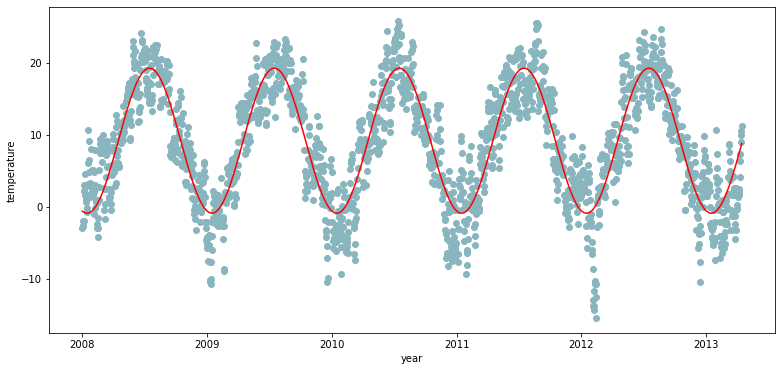

In [213]:
def f(t, a, b, c):
    return a * np.cos(2 * np.pi * t + b) + c

#load the data
data = pd.read_csv('munich_temperatures_average_with_bad_data.txt', sep=' ',header = None )
data.columns = ['year','temps']
data_fil = data[(data['year']>=2008)&(data['temps']<=60)]
year = data_fil['year']
temp = data_fil['temps']

#perform fit
par, cov = optimize.curve_fit(f, year, temp)
print('Best fit value of the parameters:')
print(f'a = {par[0]:.2f} ')
print(f'b = {par[1]:.2f} ')
print(f'c = {par[2]:.2f} ')
print("Overall average temperature in Munich:",  np.mean(data_fil['temps']), 'degrees')

#plot the data
plt.figure(figsize= (13,6))
plt.scatter(data_fil['year'],data_fil['temps'], color = '#88B5BE')
plt.plot(year, f(year, *par), 'r')
plt.xlabel('year')
plt.ylabel('temperature')
